In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

sns.set_theme(style='whitegrid')

**Set parameters**

In [3]:
alpha = 0.05
confidence = 1 - alpha

**Prepare dataset**

In [4]:
# Load the data
df = pd.read_csv("movie_metadata.csv")
df = df.drop_duplicates()
df = df.dropna(thresh=int(df.shape[1]*0.7))  # Keep rows with at least 70% non-null

In [5]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

**Research Question 1: Does IMDb Score Impact Gross Income?**

In [6]:
# Get IMBD and gross income DF
q1_df = df[['imdb_score', 'gross']].dropna()
q1_df = q1_df[q1_df['gross'] > 0]
q1_df = remove_outliers_iqr(q1_df, 'gross')

**Q1 Exploratory Data Analysis (EDA)**

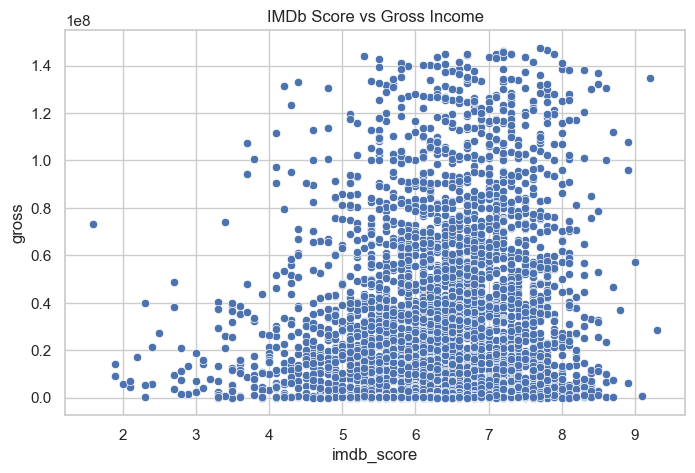

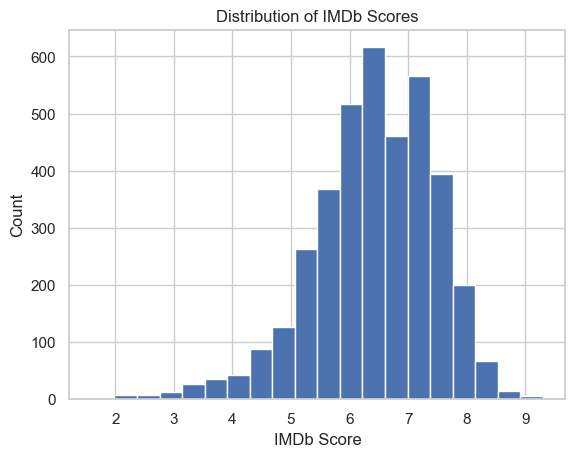

        imdb_score         gross
count  3820.000000  3.820000e+03
mean      6.418089  3.328819e+07
std       1.045678  3.531137e+07
min       1.600000  1.620000e+02
25%       5.800000  4.355251e+06
50%       6.500000  2.137471e+07
75%       7.200000  5.102578e+07
max       9.300000  1.476375e+08


,count,mean,std,min,25%,50%,75%,max
score_bin,,,,,,,,
"(0, 5]",349.0,2.540158e+07,2.725824e+07,721.0,5974653.00,16295774.0,34334256.00,133103929.0
"(5, 6]",865.0,3.283157e+07,3.211783e+07,162.0,8326035.00,23031390.0,48006503.00,144156464.0
"(6, 7]",1497.0,3.380666e+07,3.587268e+07,828.0,3093491.00,22466994.0,53215979.00,145096820.0
"(7, 8]",987.0,3.497671e+07,3.824189e+07,728.0,3437581.00,20999103.0,54211000.00,147637474.0
"(8, 9]",118.0,3.899819e+07,4.170661e+07,8060.0,4857841.25,23561450.0,63694452.25,138339411.0
"(9, 10]",4.0,4.101440e+07,6.390585e+07,447093.0,447093.00,14394281.0,54961589.75,134821952.0


In [7]:
def q1_visualize():
    # Scatter plot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=q1_df, x='imdb_score', y='gross')
    plt.title("IMDb Score vs Gross Income")
    plt.show()

    # Histogram
    q1_df['imdb_score'].hist(bins=20)
    plt.title("Distribution of IMDb Scores")
    plt.xlabel("IMDb Score")
    plt.ylabel("Count")
    plt.show()

    # Basic summary
    print(q1_df.describe())

    # Grouping by IMDb score bins for trend checking
    q1_df['score_bin'] = pd.cut(q1_df['imdb_score'], bins=[0, 5, 6, 7, 8, 9, 10])
    grouped_q1 = q1_df.groupby('score_bin', observed=False)['gross'].describe()
    display(grouped_q1)

q1_visualize()

**Q1 Statistical Inference and Formal Statistical Testing**

We will use the two-sided *Pearson Correlation Test* approach.

Null Hypothesis ($H_0$): $\rho = 0$ (there is no linear correlation between the IMDb Score and Gross Income)

Alternative Hypothesis ($H_1$): $\rho \neq 0$ (there is a linear correlation between the IMDb Score and Gross Income)

Significance Level: $\alpha = 0.05$. We will reject $H_0$ if the p-value $< 0.05$.

In [8]:
def q1_inference():
    imdb_score = q1_df['imdb_score']
    gross = q1_df['gross']

    # Correlation and R2
    pearsons = st.pearsonr(imdb_score, gross, alternative='two-sided')
    r = pearsons.statistic
    r2 = r**2
    pearsons_pvalue = pearsons.pvalue
    pearsons_is_significant = pearsons_pvalue < alpha

    print(f"Correlation (r): {r}, r2: {r2}, pvalue: {pearsons_pvalue}, significant?: {pearsons_is_significant}")

    # Confidence intervals
    confidence_interval = pearsons.confidence_interval(confidence)
    print(f"Confidence Interval [{confidence_interval.low}, {confidence_interval.high}]")

q1_inference()

Correlation (r): 0.07838095278890905, r2: 0.0061435737600971894, pvalue: 1.2327335093674215e-06, significant?: True
Confidence Interval [0.04678395057399571, 0.10982126201185084]


**Conclusion:** The scatter plot shows a faint upward trend, which suggests that a higher IMDb score might be associated with a higher gross income. This is backed by 2 tests: the Two-Sided Pearson Correlation test and the ANOVA test. The Pearson correlation test showed a positive correlation with the correlation coefficient r being very small, indicating a weak linear relationship. The p-value was less than 0.05, so the correlation was statistically significant. The ANOVA test confirmed that not all score groups have the same average gross income which supports the idea that IMDb score does have some effect. However, the weak correlation suggests that other factors likely influence the box office performance more strongly.

**Research Question 2: Is There a Trend Between Genre and Budget?**

In [9]:
# Get genre and budget DF
q2_df = df[['genres', 'budget']].dropna()
q2_df = q2_df[q2_df['budget'] > 0]
q2_df['main_genre'] = q2_df['genres'].apply(lambda x: x.split('|')[0])
q2_df = remove_outliers_iqr(q2_df, 'budget')

**Q2 Exploratory Data Analysis (EDA)**

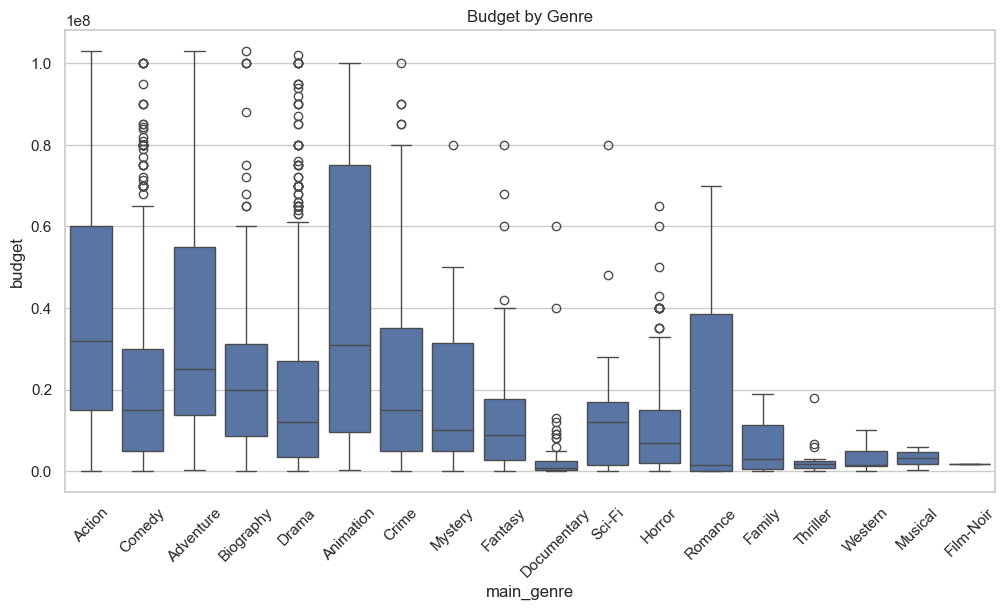

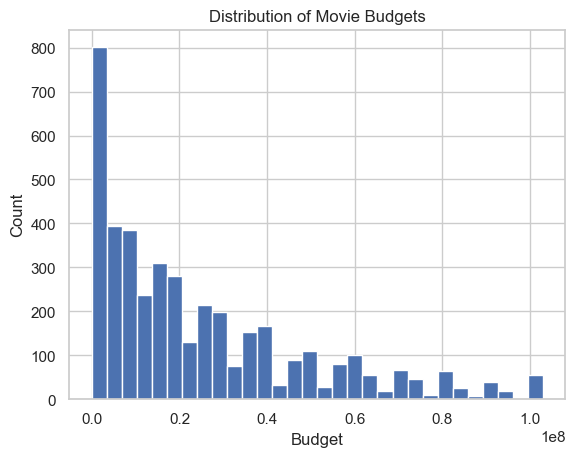

,count,mean,std,min,25%,50%,75%,max
main_genre,,,,,,,,
Action,892.0,3.777093e+07,2.733117e+07,7000.0,15000000.0,32000000.0,60000000.0,103000000.0
Adventure,348.0,3.563496e+07,2.862579e+07,150000.0,13750000.0,25000000.0,55000000.0,103000000.0
Animation,46.0,4.128000e+07,3.384898e+07,150000.0,9525000.0,31000000.0,75000000.0,100000000.0
Biography,230.0,2.339959e+07,1.965048e+07,218.0,8500000.0,20000000.0,31086250.0,103000000.0
Comedy,1155.0,2.051825e+07,2.022849e+07,9000.0,5000000.0,15000000.0,30000000.0,100000000.0
Crime,294.0,2.275143e+07,2.152829e+07,3250.0,5000000.0,15000000.0,35000000.0,100000000.0
Documentary,65.0,3.547912e+06,9.051204e+06,1100.0,250000.0,750000.0,2500000.0,60000000.0
Drama,821.0,1.925310e+07,2.125803e+07,1400.0,3500000.0,12000000.0,27000000.0,102000000.0
Family,11.0,6.010909e+06,6.910095e+06,20000.0,425000.0,3000000.0,11250000.0,19000000.0


main_genre
Comedy         1155
Action          892
Drama           821
Adventure       348
Crime           294
Biography       230
Horror          210
Documentary      65
Fantasy          46
Animation        46
Mystery          30
Thriller         16
Sci-Fi           13
Family           11
Western          11
Romance           6
Musical           2
Film-Noir         1
Name: count, dtype: int64


In [10]:
def q2_visualize():
    # Boxplot of budget by main genre
    plt.figure(figsize=(12,6))
    sns.boxplot(data=q2_df, x='main_genre', y='budget')
    plt.xticks(rotation=45)
    plt.title("Budget by Genre")
    plt.show()

    # Histogram
    q2_df['budget'].hist(bins=30)
    plt.title("Distribution of Movie Budgets")
    plt.xlabel("Budget")
    plt.ylabel("Count")
    plt.show()

    # Summary per genre
    genre_summary = q2_df.groupby('main_genre')['budget'].describe()
    display(genre_summary)

    # Number of observations per group
    print(q2_df['main_genre'].value_counts())

q2_visualize()

**Q2 Statistical Inference and Formal Statistical Testing**

We will use the one-way *ANOVA* test.

Null Hypothesis ($H_0$): All the genres have the same mean budget.

Alternative Hypothesis ($H_1$): At least one genre has a different mean budget.

Significance Level: $\alpha = 0.05$. We will reject $H_0$ if the p-value $< 0.05$.

In [15]:
def q2_inference():
    # ANOVA
    grouped_budgets = [group["budget"].values for _, group in q2_df.groupby("main_genre")]
    anova = st.f_oneway(*grouped_budgets)

    F0 = anova.statistic
    a = len(grouped_budgets)
    N = sum(len(group) for group in grouped_budgets)
    F_crit = st.f.ppf(1 - alpha, a - 1, N - a)
    reject_null = F0 > F_crit

    anova_pvalue = anova.pvalue
    anova_is_significant = anova_pvalue < alpha

    print(f"ANOVA: F0={F0}, F_crit={F_crit}, reject H0?: {reject_null}, p={anova_pvalue}, significant?: {anova_is_significant}")

    # Effect of each genre on budget
    genre_means = q2_df.groupby("main_genre")["budget"].mean()
    overall_mean = q2_df["budget"].mean()
    genre_effects = genre_means - overall_mean
    genre_effects = pd.DataFrame(genre_effects)
    print(genre_effects)

q2_inference()

ANOVA: F0=39.563500006321725, F_crit=1.6252156539264053, reject H0?: True, p=8.153185203104459e-122, significant?: True
                   budget
main_genre               
Action       1.302047e+07
Adventure    1.088451e+07
Animation    1.652954e+07
Biography   -1.350866e+06
Comedy      -4.232210e+06
Crime       -1.999028e+06
Documentary -2.120254e+07
Drama       -5.497354e+06
Family      -1.873955e+07
Fantasy     -1.038752e+07
Film-Noir   -2.305408e+07
Horror      -1.355632e+07
Musical     -2.156096e+07
Mystery     -5.938290e+06
Romance     -4.191623e+06
Sci-Fi      -7.568149e+06
Thriller    -2.179064e+07
Western     -2.154727e+07


**Conclusion:** The Boxplot visual showed the budget distribution for each genre in the IMDb data set and highlighted that some genres had visibly higher budgets than others. This allowed us to safely assume that genre does have an effect on the budget. This is further backed by our statistical testing using the ANOVA test which showed a large F value and a p-value less than 0.05. This indicates that at least one genre has a different average budget.  Which means that our null hypothesis, stating that all genres have the same average budget was rejected.  This result supports the conclusion that genre plays a meaningful role in budget allocation, and movie production should heavily consider a genre when approving the movie's budget. 

**Research Question 3: Does the Director’s Name Influence the Number of Votes?**

In [12]:
# Get director's name and number of votes DF
q3_df = df[['director_name', 'num_voted_users']].dropna()
q3_df = q3_df[q3_df['num_voted_users'] > 0]
q3_df = remove_outliers_iqr(q3_df, 'num_voted_users')

**Q3 Exploratory Data Analysis (EDA)**

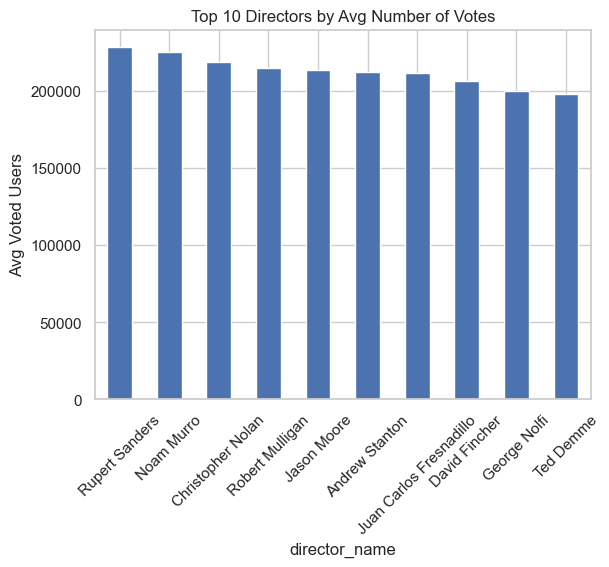

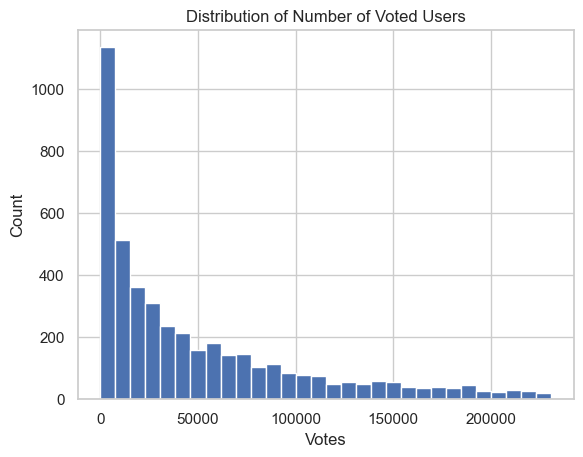

       num_voted_users
count      4437.000000
mean      49484.892044
std       54663.159487
min           5.000000
25%        7354.000000
50%       28621.000000
75%       73539.000000
max      230931.000000


,count,mean,std,min,25%,50%,75%,max
director_name,,,,,,,,
Rupert Sanders,1.0,228554.0,NaN,228554.0,228554.0,228554.0,228554.0,228554.0
Noam Murro,1.0,225273.0,NaN,225273.0,225273.0,225273.0,225273.0,225273.0
Christopher Nolan,1.0,218771.0,NaN,218771.0,218771.0,218771.0,218771.0,218771.0
Robert Mulligan,1.0,215086.0,NaN,215086.0,215086.0,215086.0,215086.0,215086.0
Jason Moore,1.0,213898.0,NaN,213898.0,213898.0,213898.0,213898.0,213898.0
Andrew Stanton,1.0,212204.0,NaN,212204.0,212204.0,212204.0,212204.0,212204.0
Juan Carlos Fresnadillo,1.0,212167.0,NaN,212167.0,212167.0,212167.0,212167.0,212167.0
David Fincher,2.0,206895.0,1118.642928,206104.0,206499.5,206895.0,207290.5,207686.0
George Nolfi,1.0,200035.0,NaN,200035.0,200035.0,200035.0,200035.0,200035.0


In [13]:
def q3_visualize():
    # Top 10 directors by average number of votes
    top_directors = q3_df.groupby('director_name')['num_voted_users'].mean().sort_values(ascending=False).head(10)
    top_directors.plot(kind='bar')
    plt.title("Top 10 Directors by Avg Number of Votes")
    plt.ylabel("Avg Voted Users")
    plt.xticks(rotation=45)
    plt.show()

    # Histogram of votes
    q3_df['num_voted_users'].hist(bins=30)
    plt.title("Distribution of Number of Voted Users")
    plt.xlabel("Votes")
    plt.ylabel("Count")
    plt.show()

    # Summary
    print(q3_df.describe())

    # Grouping by director
    director_summary = q3_df.groupby('director_name')['num_voted_users'].describe().sort_values(by='mean', ascending=False)
    display(director_summary.head(10))

q3_visualize()

**Q3 Statistical Inference and Formal Statistical Testing**

We will use the one-way *ANOVA* test.

Null Hypothesis ($H_0$): All the directors have the same mean number of votes.

Alternative Hypothesis ($H_1$): At least one director has a different mean number of votes.

Significance Level: $\alpha = 0.05$. We will reject $H_0$ if the p-value $< 0.05$.

In [14]:
def q3_inference():
    # ANOVA
    grouped_budgets = [group["num_voted_users"].values for _, group in q3_df.groupby("director_name")]
    anova = st.f_oneway(*grouped_budgets)

    F0 = anova.statistic
    a = len(grouped_budgets)
    N = sum(len(group) for group in grouped_budgets)
    F_crit = st.f.ppf(1 - alpha, a - 1, N - a)
    reject_null = F0 > F_crit

    anova_pvalue = anova.pvalue
    anova_is_significant = anova_pvalue < alpha

    print(f"ANOVA: F0={F0}, F_crit={F_crit}, reject H0?: {reject_null}, p={anova_pvalue}, significant?: {anova_is_significant}")

    # Effect of each director on votes
    director_means = q3_df.groupby("director_name")["num_voted_users"].mean()
    overall_mean = q3_df["num_voted_users"].mean()
    director_effects = director_means - overall_mean

    print("\nDirector effects on votes (difference from overall mean):")
    for director_name, effect in director_effects.items():
        print(f"{director_name}: {effect:.2f}")

q3_inference()

ANOVA: F0=1.5079854291798063, F_crit=1.0726284285521668, reject H0?: True, p=5.159543329481513e-22, significant?: True

Director effects on votes (difference from overall mean):
A. Raven Cruz: -48950.89
Aaron Hann: -36205.89
Aaron Schneider: -30337.89
Aaron Seltzer: 930.11
Abel Ferrara: -42563.89
Adam Brooks: 78275.11
Adam Carolla: -48133.89
Adam Goldberg: -47866.89
Adam Green: -26135.89
Adam Jay Epstein: -39924.89
Adam Marcus: -30153.89
Adam McKay: 119973.31
Adam Rapp: -42256.89
Adam Rifkin: -34103.39
Adam Shankman: 25031.98
Adrian Lyne: -3752.14
Adrienne Shelly: -11770.89
Agnieszka Holland: -38352.89
Agnieszka Wojtowicz-Vosloo: -18648.89
Agustín Díaz Yanes: -39218.89
Aki Kaurismäki: -34217.89
Akira Kurosawa: 66754.11
Akiva Goldsman: -8196.89
Akiva Schaffer: 39861.11
Al Franklin: -49460.89
Al Silliman Jr.: -49323.89
Alain Resnais: -46310.89
Alan Alda: -46327.89
Alan Cohn: -37755.89
Alan J. Pakula: 3100.61
Alan Jacobs: -49227.89
Alan Metter: -24526.89
Alan Parker: -4661.56
Alan Poul: -

**Conclusion:** ANOVA test showed that there is a difference in the average number of votes across the movie directors meaning that a movie's director influences the number of votes the film will receive from the audience (p-value is very small). The possible implication of this finding: the movie productions should consider collaborating with the popular and highly-rated directors to boost the total number of votes.